<a href="https://colab.research.google.com/github/ailab-nda/ML/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM による時系列データの予測
http://sweng.web.fc2.com/ja/program/python/time-series-forecast-lstm.html

## ライブラリのインポート

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set()

## 簡単な例
3つの入力から、2つの値を出力(予測)することにします。

In [3]:
# 学習用データ。xが入力、yが出力(答え)です。

x = np.array([[10,20,30], [20,30,40], [30, 40, 50], [40, 50, 60]])
y = np.array([[40, 50], [50, 60], [60, 70], [70, 80]])

# 行列のフォーマット変更。
# LSTMは、入力フォーマットを[サンプルの数, 入力のステップ数(この場合は3), features]とする必要があるためです。
x = x.reshape((x.shape[0], x.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))

ネットワークの構築

In [4]:
m = Sequential()
m.add(LSTM(100, activation='relu', input_shape=(3, 1)))
m.add(RepeatVector(2))
m.add(LSTM(100, activation='relu', return_sequences=True))
m.add(TimeDistributed(Dense(1)))
m.compile(optimizer='adam', loss='mse')

学習（時間が少しかかる可能性があります。）

In [5]:
m.fit(x, y, epochs=1000, verbose=0)

学習済みのモデルに、[50, 60, 70]という入力を与えて、結果がどうなるかを見てみます。 理想では[80, 90]となればOKです。

In [6]:
x_input = np.array([50, 60, 70])
x_input = x_input.reshape((1, 3, 1))
yhat = m.predict(x_input)
print(yhat)

1/1 [==============================] - 1s 1s/step
[[[81.64077 ]
  [92.239494]]]


## AirPassengers.csv を使った予測
次に、AirPassengers.csvのデータで試してみます。 このデータは色々なところで勉強用に使われているので、"AirPassengers.csv"でググれば、データは見つかります。

データの読み込み

In [8]:
df = pd.read_csv('AirPassengers.csv', index_col='Month', dtype={1: 'float'})
ts = df['#Passengers']
df

,#Passengers
Month,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0
...,...
1960-08,606.0
1960-09,508.0
1960-10,461.0


学習用データxと、回答データyを用意します。 AirPassengersのデータは、「毎月の乗客数」です。10年分くらいのデータがあるので、その一部を学習用に使います。 2年間のデータ(24データ)を用いて、次に一年(12データ)を予測するように学習します。

In [9]:
x = [] # train
y = [] # test (answer)
for i in range(0, 72):
    tmpX = []
    for j in range(0, 24):
        tmpX.append(ts[i+j])
    x.append(tmpX)

    tmpY = []
    for j in range(0, 12):
        tmpY.append(ts[24+i+j])
    y.append(tmpY)

学習用データxと、回答データyができたので、numpy配列にして、LSTM用にreshapeします。

In [10]:
x = np.array(x)
y = np.array(y)
x = x.reshape((x.shape[0], x.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))

ネットワークを組み、学習します。

In [13]:
m = Sequential()
# 入力データ数が24なので、input_shapeの値が(24,1)です。
m.add(LSTM(100, activation='relu', input_shape=(24, 1)))
# 予測範囲は12ステップなので、RepeatVectoorに12を指定する必要があります。
m.add(RepeatVector(12))
m.add(LSTM(100, activation='relu', return_sequences=True))
m.add(TimeDistributed(Dense(1)))
m.compile(optimizer='adam', loss='mse')
m.fit(x, y, epochs=1000, verbose=0)

いざ、予測してみます。

1/1 [==============================] - 0s 361ms/step


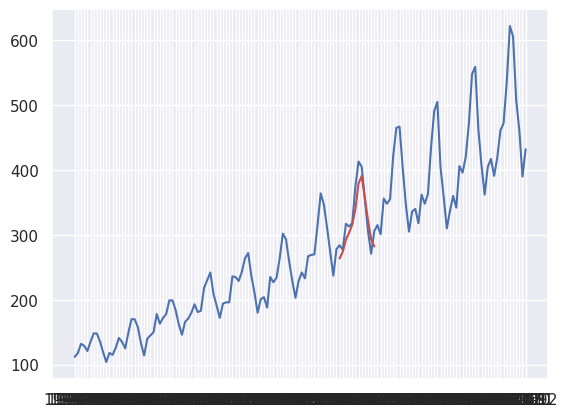

In [14]:
# データ60番～83番から、次の一年(84番～95番)を予測
input = np.array(ts[60:84])
input = input.reshape((1,24,1))
yhat = m.predict(input)

# 可視化用に、予測結果yhatを、配列predictに格納
predict = []
for i in range(0, 12):
    predict.append(yhat[0][i])

# 比較するために実データをプロット
plt.plot(ts)

# 予測したデータをプロット
xdata = np.arange(84, 96, 1)
plt.plot(xdata, predict, 'r')